Created on Thu Apr 17 15:58:33 2020

@author: Ruchilekha

Dataset used : https://github.com/UCSD-AI4H/COVID-CT
COVID-CT-Dataset: A CT Scan Dataset about COVID-19
Reference paper: Jinyu Zhao, Yichen Zhang, Xuehai He, Pengtao Xie: “COVID-CT-Dataset: A CT Scan Dataset about COVID-19” 
                 https://arxiv.org/pdf/2003.13865.pdf, 30 March 2020. 

In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

import cv2
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil 

def find_accuracy(actual, predicted):
    print("accuracy=",accuracy_score(actual, predicted))
    print("precision, recall, fscore, support=",precision_recall_fscore_support(actual, predicted, average='macro'))

train_data_dir = "C://Users//DELL//Downloads//CT Scan Database"


# Directory with COVID CT ScanS
covid_dir = os.path.join(r"C://Users//DELL//Downloads//CT Scan Database//CT_COVID")

# Directory with COVID_marked CT ScanS
covid_mark_dir = os.path.join(r"C://Users//DELL//Downloads//CT Scan Database//COVID_marked")

# Directory with Non-COVID CT Scans
noncovid_dir = os.path.join(r"C://Users//DELL//Downloads//CT Scan Database//CT_NonCOVID")

covid_names = os.listdir(covid_dir)
print(covid_names[:10])

noncovid_names = os.listdir(noncovid_dir)
print(noncovid_names[:10])

print('total COVID CT ScanS:', len(os.listdir(covid_dir)))
print('total Non-COVID CT Scans:', len(os.listdir(noncovid_dir)))
print('total COVID marked CT ScanS:', len(os.listdir(covid_mark_dir)))

get_ipython().run_line_magic('matplotlib', 'inline')

['2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png', '2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%1.png', '2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-91.png', '2020.01.24.919183-p27-132.png', '2020.01.24.919183-p27-133.png', '2020.01.24.919183-p27-134.png', '2020.01.24.919183-p27-135.png', '2020.02.10.20021584-p6-52%0.png', '2020.02.10.20021584-p6-52%1.png', '2020.02.10.20021584-p6-52%10.png']
['0.jpg', '1%0.jpg', '1%1.jpg', '1%2.jpg', '10%0.jpg', '10%1.jpg', '10%2.jpg', '102.png', '1029.png', '103.png']
total COVID CT ScanS: 358
total Non-COVID CT Scans: 397
total COVID marked CT ScanS: 43


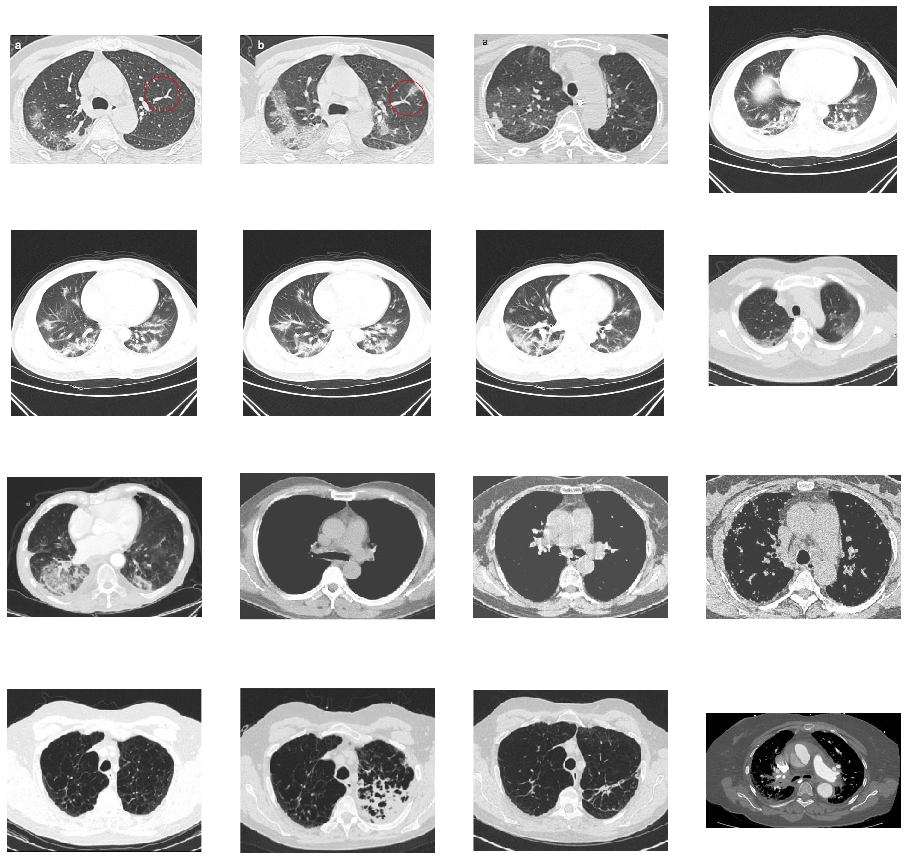

In [2]:
#DISPLAYING SOME PICTURES

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 6
ncols = 4

# Index for iterating over images
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_covid_pix = [os.path.join(covid_dir, fname) 
                for fname in covid_names[pic_index-8:pic_index]]
next_noncovid_pix = [os.path.join(noncovid_dir, fname) 
                for fname in noncovid_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_covid_pix+next_noncovid_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [7]:
#Standardize the pixel values
def lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    #plt.imshow(img)
    
    #ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
    #ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
    #ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
    #ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)
    
    #th6 = cv2.adaptiveThreshold(img_grey,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,75,2)
    #th7 = cv2.adaptiveThreshold(img_grey,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,75,2)
    #ret,th8 = cv2.threshold(img_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #blur = cv2.GaussianBlur(img_grey,(5,5),0)
    #ret,th9 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    thresh_img = thresh2
    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = cv2.erode(thresh_img,np.ones([3,3]))
    dilation = cv2.dilate(eroded,np.ones([8,8]))
    #plt.imshow(dilation)      

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Infected areas of lungs")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Infected areas of lungs mapped on original image")
        ax[2, 1].imshow(mask*img)
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

In [8]:

import glob
covid = glob.glob(covid_dir+"/*.*")
noncovid = glob.glob(noncovid_dir+"/*.*")
covid_marked = glob.glob(covid_mark_dir+"/*.*")


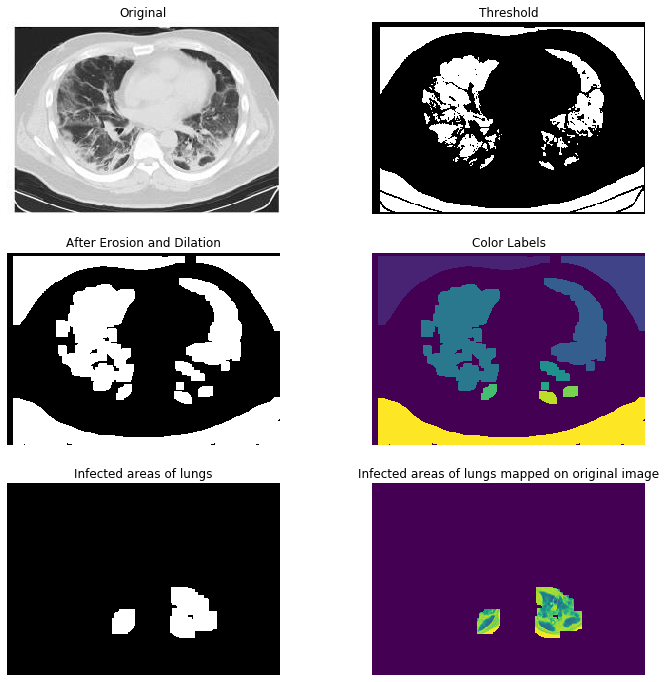

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
raw_img = cv2.imread(covid[10])
img_grey = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
img = img_grey
lungmask(img_grey, display=True)

In [10]:
def sample_stack(stack, rows=6, cols=6, start_with=1, show_every=5):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()


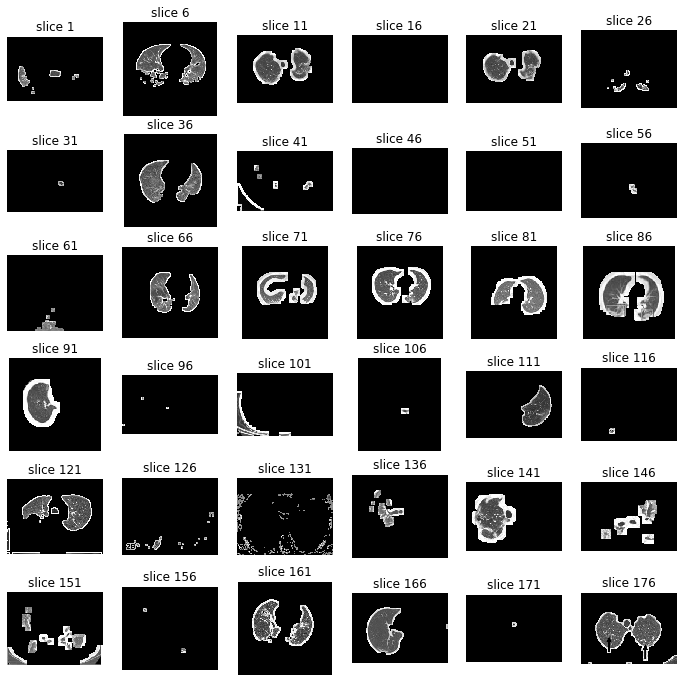

In [12]:
masked_CT = []
masked_label = []

for img in covid:
    raw_img = cv2.imread(img)
    img_grey = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
    img = img_grey
    masked_CT.append(lungmask(img))
    masked_label.append(0)

sample_stack(masked_CT)